# Clustering with MLlib and PySpark

Available algorithm in PySpark:

1. K-means (dividing data into groups or clusters, based on distance and centroids..)
2. Latent Dirichlet allocation (LDA) - for discovering topics, dna analysis, tweet threads
3. Bisecting k-menas ..bisecting splitting meaning 1-2-4-8 ..
4. Gaussian Mixture Model (GMM) - soft clustering (k-means = hard)

## K-Means & Bisecting K-Means

In [1]:
import pyspark 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("kmeans").getOrCreate()

In [2]:
spark

<div class="alert alert-block alert-warning"><b>Data</b></div>

**Import dataset**

**Content**

This dataset summarizes the usage behavior of about 9,000 credit card holders during the last 6 months that we will use to define a marketing outreach strategy for. Basically we want to see how we can get our customers to purchase more! The file is at a customer level with 18 behavioral variables.

**Data Dictionary:**

 - **CUST_ID:** Identification of Credit Card holder (Categorical) 
 - **BALANCE:** Balance amount left in their account to make purchases 
 - **BALANCE_FREQUENCY:** How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated) 
 - **PURCHASES:** Amount of purchases made from account 
 - **ONEOFF_PURCHASES:** Maximum purchase amount done in one-go 
 - **INSTALLMENTS_PURCHASES:** Amount of purchase done in installment 
 - **CASH_ADVANCE:** Cash in advance given by the user 
 - **PURCHASES_FREQUENCY:** How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased) 
 - **ONEOFFPURCHASESFREQUENCY:** How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased) 
 - **PURCHASESINSTALLMENTSFREQUENCY:** How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done) 
 - **CASHADVANCEFREQUENCY:** How frequently the cash in advance being paid 
 - **CASHADVANCETRX:** Number of Transactions made with "Cash in Advanced" 
 - **PURCHASES_TRX:** Number of purchase transactions made 
 - **CREDIT_LIMIT:** Limit of Credit Card for user 
 - **PAYMENTS:** Amount of Payment done by user 
 - **MINIMUM_PAYMENTS:** Minimum amount of payments made by user 
 - **PRCFULLPAYMENT:** Percent of full payment paid by user TENURE : Tenure of credit card service for user

**Source:** https://www.kaggle.com/arjunbhasin2013/ccdata

In [3]:
path ="Datasets/"
df = spark.read.csv(path+'credit_card_data.csv',inferSchema=True,header=True)

In [4]:
df.limit(5).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [5]:
df.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)



<div class="alert alert-block alert-warning"><b>Checking the null values</b></div>

In [6]:
from pyspark.sql.functions import *

In [7]:
def null_value_calc(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where(col(k).isNull()).count()
        if(nullRows > 0):
            temp = k,nullRows,(nullRows/numRows)*100
            null_columns_counts.append(temp)
    return(null_columns_counts)

In [8]:
null_columns_calc_list = null_value_calc(df)
spark.createDataFrame(null_columns_calc_list, ['Column_Name', 'Null_Values_Count','Null_Value_Percent']).show()

+----------------+-----------------+------------------+
|     Column_Name|Null_Values_Count|Null_Value_Percent|
+----------------+-----------------+------------------+
|    CREDIT_LIMIT|                1|0.0111731843575419|
|MINIMUM_PAYMENTS|              313|3.4972067039106145|
+----------------+-----------------+------------------+



<div class="alert alert-block alert-warning"><b>Filling Nan with average</b></div>

In [9]:
def fill_with_mean(df, include=set()): 
    stats = df.agg(*(avg(c).alias(c) for c in df.columns if c in include))
    return df.na.fill(stats.first().asDict())

*Filling Nan.*

In [12]:
columns = df.columns
columns = columns[1:]
df = fill_with_mean(df, columns)

In [18]:
null_value_calc(df) #check if empty 

[]

<div class="alert alert-block alert-warning"><b>Convert all features into a vector</b></div>

*Note: no label here, so we don 't need any splitting.*

In [19]:
from pyspark.ml.feature import VectorAssembler
input_columns = df.columns #al of my columns
input_columns = input_columns[1:] # the first one is not useful..
vecAssembler = VectorAssembler(inputCols=input_columns, outputCol="features")
df_kmeans = vecAssembler.transform(df) 
df_kmeans.limit(4).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,features
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,"[40.900749, 0.818182, 95.4, 0.0, 95.4, 0.0, 0...."
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,"(3202.467416, 0.909091, 0.0, 0.0, 0.0, 6442.94..."
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,"[2495.148862, 1.0, 773.17, 773.17, 0.0, 0.0, 1..."
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,"[1666.670542, 0.636364, 1499.0, 1499.0, 0.0, 2..."


Data prepared and vectorized, now let's proceed with K-Means.

<div class="alert alert-block alert-warning"><b>K-means</b></div>

In [20]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

In [22]:
kmax = 50 #just a number of maximum cluster
kmcost = np.zeros(kmax) #for cost calculation
for k in range(2,kmax): #trying to split our data from 2-50 clusters
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features") #setting my algorithm
    model = kmeans.fit(df_kmeans) #fitting our data
    # Computes the "cost" (sum of squared distances) between the input points and their corresponding cluster centers.
    predictions = model.transform(df_kmeans)
    evaluator = ClusteringEvaluator()
    kmcost[k] = evaluator.evaluate(predictions) 

*Now lets plot our elbow chart.*

Text(0, 0.5, 'cost')

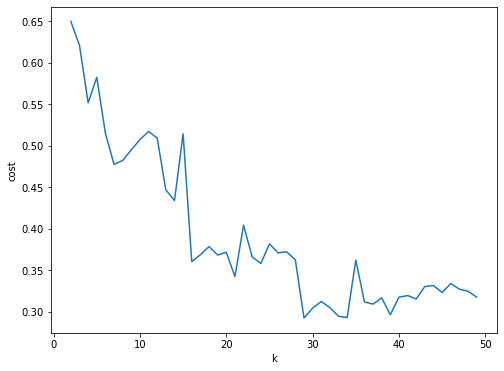

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,kmax),kmcost[2:kmax])
ax.set_xlabel('k')
ax.set_ylabel('cost')

Well I guess I can be happy that I have some shape :). It's a little bit tricky I would like to have smaller number of clusters but the results from 10-20 are not consistent.

<div class="alert alert-block alert-warning"><b>Bisecting k-menas</b></div>

The same procedure but with a lisghtly different K-means.

In [24]:
from pyspark.ml.clustering import BisectingKMeans
kmax = 50
bkmcost = np.zeros(kmax)
for k in range(2,kmax):
    bkmeans = BisectingKMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = bkmeans.fit(df_kmeans)
    predictions = model.transform(df_kmeans)
    evaluator = ClusteringEvaluator()
    bkmcost[k] = evaluator.evaluate(predictions) #computes Silhouette score

Text(0, 0.5, 'cost')

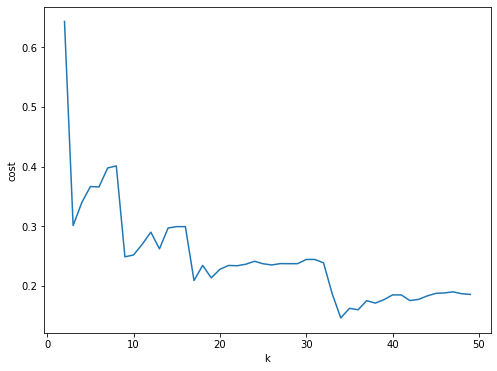

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,kmax),bkmcost[2:kmax])
ax.set_xlabel('k')
ax.set_ylabel('cost')

<div class="alert alert-block alert-warning"><b>Coparison</b></div>

We have two main approach for comparing two cluster method and these are:

1. plotting together
2. calculate i cost values for j k values

Text(0, 0.5, 'cost')

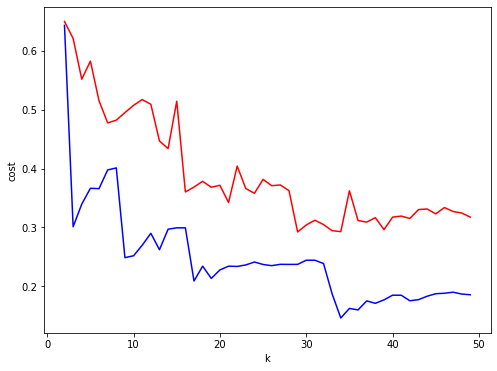

In [26]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.plot(range(2,kmax),bkmcost[2:kmax],color='blue')
ax.plot(range(2,kmax),kmcost[2:kmax],color='red')
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [27]:
def compare(bkmcost,kmcost):
    diff = []
    for k in range(2,kmax,5):
        temp = k,(kmcost[k]-bkmcost[k])
        diff.append(temp)
    return(diff)

diff_list = compare(bkmcost,kmcost)
diff_list

[(2, 0.006652107175816435),
 (7, 0.07988236737114579),
 (12, 0.21917034747450276),
 (17, 0.15966945027119617),
 (22, 0.17042334621100996),
 (27, 0.13480360778428596),
 (32, 0.06617604511056815),
 (37, 0.13386153955302815),
 (42, 0.13985887359735294),
 (47, 0.13713663096880555)]

Its cleary evident that our Bisect K-menas is performing better.

<div class="alert alert-block alert-warning"><b>Final Model</b></div>

In [35]:
k = 3 #I am choosing K so low just to make results visible 

bkmeans = BisectingKMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = bkmeans.fit(df_kmeans)

predictions = model.transform(df_kmeans)


evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))
print(" ")

# Shows the cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.3011137239104424
 
Cluster Centers: 
[7.48653561e+02 8.47441104e-01 4.52753333e+02 2.12632529e+02
 2.40348478e+02 4.20879612e+02 4.41458728e-01 1.16591629e-01
 3.43004324e-01 1.05917520e-01 2.15786177e+00 8.73355607e+00
 1.94616679e+03 7.94352986e+02 6.29433262e+02 1.40931358e-01
 1.13361871e+01]
[1.36228132e+03 8.87531107e-01 1.01021728e+03 5.79972124e+02
 4.30628179e+02 7.88249684e+02 5.36920836e-01 2.62652115e-01
 3.74818266e-01 1.18688008e-01 2.74386435e+00 1.60602410e+01
 5.37198807e+03 1.53941482e+03 5.96593842e+02 1.84627880e-01
 1.17139670e+01]
[3.83535175e+03 9.39698093e-01 2.36799511e+03 1.55432279e+03
 8.14056672e+02 2.59314399e+03 5.57943733e-01 3.46372692e-01
 4.05780605e-01 2.27250919e-01 6.55937500e+00 2.80401042e+01
 9.82630445e+03 4.30086064e+03 1.76214889e+03 1.49518101e-01
 1.17395833e+01]


These data are just not very informative to us. Lest create a table for these.

In [36]:
import pandas as pd
import numpy as np
center_pdf = pd.DataFrame(list(map(np.ravel,centers)))
center_pdf.columns = columns
center_pdf

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,748.653561,0.847441,452.753333,212.632529,240.348478,420.879612,0.441459,0.116592,0.343004,0.105918,2.157862,8.733556,1946.166794,794.352986,629.433262,0.140931,11.336187
1,1362.281321,0.887531,1010.217282,579.972124,430.628179,788.249684,0.536921,0.262652,0.374818,0.118688,2.743864,16.060241,5371.988067,1539.414816,596.593842,0.184628,11.713967
2,3835.351753,0.939698,2367.995115,1554.322792,814.056672,2593.143987,0.557944,0.346373,0.405781,0.227251,6.559375,28.040104,9826.304451,4300.860637,1762.148887,0.149518,11.739583


In [47]:
predictions.limit(6).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,features,prediction
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,"[40.900749, 0.818182, 95.4, 0.0, 95.4, 0.0, 0....",0
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,"(3202.467416, 0.909091, 0.0, 0.0, 0.0, 6442.94...",2
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,"[2495.148862, 1.0, 773.17, 773.17, 0.0, 0.0, 1...",1
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,"[1666.670542, 0.636364, 1499.0, 1499.0, 0.0, 2...",1
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,"[817.714335, 1.0, 16.0, 16.0, 0.0, 0.0, 0.0833...",0
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12,"[1809.828751, 1.0, 1333.28, 0.0, 1333.28, 0.0,...",0


My prediction contains values only 0,1,2 so I was able to cluster my data.

## Latent Dirichlet Allocation

In [48]:
import pyspark 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("LDA").getOrCreate()
spark

<div class="alert alert-block alert-warning"><b>Data</b></div>

In [49]:
from pyspark.sql.types import *
from pyspark.ml.feature import *
from pyspark.ml.clustering import LDA
from pyspark.sql.functions import *
from pyspark.ml import Pipeline 

**Dataset**

This JSON lines file contains 1600 christmas cooking recipes scraped from BBC Good Food.

**Content**

 - Recipe Title
 - Recipe Description (we are going to focus on this variable for our analysis)
 - Recipe Author
 - Ingredients list
 - Step by step method

**Source:** https://www.yanlong.app/gjbroughton/christmas-recipes


In [50]:
path = 'Datasets/'
df = spark.read.json(path+'recipes.json')
df.limit(5).toPandas()

,Author,Description,Ingredients,Method,Name,url
0,Mary Cadogan,Combine a few key Christmas flavours here to m...,"[2 tbsp olive oil, knob butter, 1 onion, finel...",[Heat oven to 190C/fan 170C/gas 5. Heat 1 tbsp...,Christmas pie,https://www.bbcgoodfood.com/recipes/2793/chris...
1,Mary Cadogan,An easy-to-make alternative to traditional Chr...,"[175g butter, chopped, 200g dark muscovado sug...","[Put the butter, sugar, fruit, zests, juice an...",Simmer-&-stir Christmas cake,https://www.bbcgoodfood.com/recipes/1160/simme...
2,Sara Buenfeld,These beautiful and classy little cakes make l...,"[200g dark muscovado sugar, 175g butter, chopp...","[Tip the sugar, butter, dried fruit, whole che...",Christmas cupcakes,https://www.bbcgoodfood.com/recipes/72622/chri...
3,Paul Hollywood,Paul Hollywood's fruit rolls can be made ahead...,"[500g strong white flour, plus extra for dusti...",[Put the flour and 1 tsp salt into a large bow...,Christmas buns,https://www.bbcgoodfood.com/recipes/1803633/ch...
4,Barney Desmazery,"Made these for the second time today, and I ha...","[280g self-raising flour, 175g golden caster s...",[Heat oven to 190C/170 fan/gas 5 and line a 12...,Christmas cupcakes,https://www.bbcgoodfood.com/recipes/981634/chr...


In [51]:
df.printSchema()

root
 |-- Author: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Ingredients: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Method: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Name: string (nullable = true)
 |-- url: string (nullable = true)



**Missing values**

In [52]:
def null_value_calc(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where(col(k).isNull()).count()
        if(nullRows > 0):
            temp = k,nullRows,(nullRows/numRows)*100
            null_columns_counts.append(temp)
    return(null_columns_counts)

null_columns_calc_list = null_value_calc(df)
spark.createDataFrame(null_columns_calc_list, ['Column_Name', 'Null_Values_Count','Null_Value_Percent']).show()

+-----------+-----------------+------------------+
|Column_Name|Null_Values_Count|Null_Value_Percent|
+-----------+-----------------+------------------+
|     Author|                6|0.3710575139146568|
|Description|              188|11.626468769325912|
+-----------+-----------------+------------------+



Sice the description is the most important column here, I wont be trying to replace values, so rows will be dropped.

In [53]:
df.count()

1617

In [54]:
df = df.na.drop(subset=["Description"])
df.count()

1429

<div class="alert alert-block alert-warning"><b>Data Preparation - NLP part</b></div>

- Clean text
- Tokenize
- Stopwords
- Vectorizing

**Cleaning**

In [55]:
df.select('Description').show(2,False)

+------------------------------------------------------------------------------------------------+
|Description                                                                                     |
+------------------------------------------------------------------------------------------------+
|Combine a few key Christmas flavours here to make a pie that both children and adults will adore|
|An easy-to-make alternative to traditional Christmas cakes which requires no beating            |
+------------------------------------------------------------------------------------------------+
only showing top 2 rows



Nothing to see here, so we will just use a classic method for deleting special characters.

In [56]:
# Removing anything that is not a letter
df_clean = df.withColumn("Description",lower(regexp_replace(col('Description'), '[^A-Za-z ]+', ' ')))
# Remove multiple spaces (because we replaced punctuation with a space)
df_clean = df_clean.withColumn("Description",regexp_replace(col('Description'), ' +', ' '))
df_clean.select('Description').show(2,False)

+------------------------------------------------------------------------------------------------+
|Description                                                                                     |
+------------------------------------------------------------------------------------------------+
|combine a few key christmas flavours here to make a pie that both children and adults will adore|
|an easy to make alternative to traditional christmas cakes which requires no beating            |
+------------------------------------------------------------------------------------------------+
only showing top 2 rows



**Tokenize, stopwords, vectorize**

In [57]:
# Tokenize
regex_tokenizer = RegexTokenizer(inputCol="Description", outputCol="words", pattern="\\W")
raw_words = regex_tokenizer.transform(df_clean)

# Stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
words_df = remover.transform(raw_words)

# Zero Index Label Column
cv = CountVectorizer(inputCol="filtered", outputCol="features")
cvmodel = cv.fit(words_df)
df_vect = cvmodel.transform(words_df)

In [58]:
df_vect.limit(4).toPandas()

,Author,Description,Ingredients,Method,Name,url,words,filtered,features
0,Mary Cadogan,combine a few key christmas flavours here to m...,"[2 tbsp olive oil, knob butter, 1 onion, finel...",[Heat oven to 190C/fan 170C/gas 5. Heat 1 tbsp...,Christmas pie,https://www.bbcgoodfood.com/recipes/2793/chris...,"[combine, a, few, key, christmas, flavours, he...","[combine, key, christmas, flavours, make, pie,...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Mary Cadogan,an easy to make alternative to traditional chr...,"[175g butter, chopped, 200g dark muscovado sug...","[Put the butter, sugar, fruit, zests, juice an...",Simmer-&-stir Christmas cake,https://www.bbcgoodfood.com/recipes/1160/simme...,"[an, easy, to, make, alternative, to, traditio...","[easy, make, alternative, traditional, christm...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
2,Sara Buenfeld,these beautiful and classy little cakes make l...,"[200g dark muscovado sugar, 175g butter, chopp...","[Tip the sugar, butter, dried fruit, whole che...",Christmas cupcakes,https://www.bbcgoodfood.com/recipes/72622/chri...,"[these, beautiful, and, classy, little, cakes,...","[beautiful, classy, little, cakes, make, lovel...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Paul Hollywood,paul hollywood s fruit rolls can be made ahead...,"[500g strong white flour, plus extra for dusti...",[Put the flour and 1 tsp salt into a large bow...,Christmas buns,https://www.bbcgoodfood.com/recipes/1803633/ch...,"[paul, hollywood, s, fruit, rolls, can, be, ma...","[paul, hollywood, fruit, rolls, made, ahead, h...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


And that's it, very straightforwad, now I can procced with LDA.

<div class="alert alert-block alert-warning"><b>LDA looking for K value</b></div>

**Basic info**

This portion is going to be more like our k-means analysis where we plot our results and look for the elbow except this time we will be using the following metrics (the only ones PySpark provides):

**Log likelihood:** Calculates a lower bound on the log likelihood of the entire corpus. We want higher numbers here. See Equation (16) in the Online LDA paper (Hoffman et al., 2010).

**Log Perplexity:** Calculate an upper bound on perplexity. See Equation (16) in the Online LDA paper (Hoffman et al., 2010). We want lower numbers here, however keep in mind that this evaluation metric is debatable as many have shown that, surprisingly, perplexity and human judgment are often not correlated, and even sometimes slightly anti-correlated. Here is one interesting paper here on the subject: http://qpleple.com/perplexity-to-evaluate-topic-models/

Text(0, 0.5, 'lp')

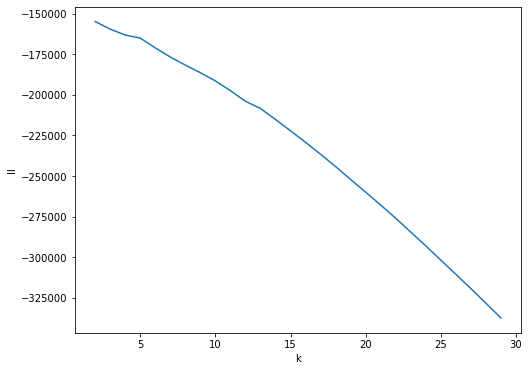

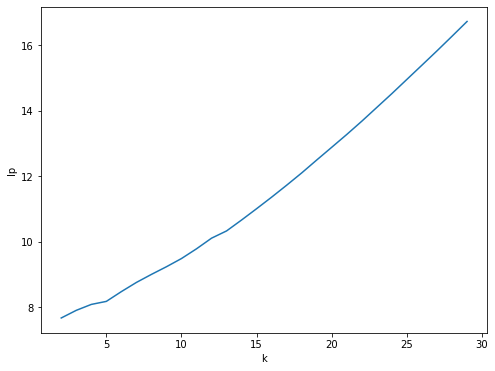

In [59]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

kmax = 30
ll = np.zeros(kmax)
lp = np.zeros(kmax)
for k in range(2,kmax):
    lda = LDA(k=k, maxIter=10)
    model = lda.fit(df_vect)
    ll[k] = model.logLikelihood(df_vect)
    lp[k] = model.logPerplexity(df_vect)
    
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,kmax),ll[2:kmax])
ax.set_xlabel('k')
ax.set_ylabel('ll')

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,kmax),lp[2:kmax])
ax.set_xlabel('k')
ax.set_ylabel('lp')

*Better to choose lower K, but that make sense. More k = probably bad topic names.*

<div class="alert alert-block alert-warning"><b>Final LDA model</b></div>

In [60]:
lda = LDA(k=5, maxIter=10)
model = lda.fit(df_vect)

In [61]:
print("Recap of ll and lp:")
ll = model.logLikelihood(df_vect)
lp = model.logPerplexity(df_vect)
print("The lower bound on the log likelihood of the entire corpus: " + str(ll))
print("The upper bound on perplexity: " + str(lp))
print("Vocab Size: ", model.vocabSize())

# Describe topics.
print("The topics described by their top-weighted terms:")
topics = model.describeTopics(maxTermsPerTopic = 4)
# topics.show(truncate=False)
topics = topics.collect()
vocablist = cvmodel.vocabulary
# Enumerate adds a counter to topics and returns it in a form of enumerate object. 
for x, topic in enumerate(topics):
    print(" ")
    print('TOPIC: ' + str(x))
    # This is like a temp holder
    topic = topics
    # Then we extract the words from the topics
    words = topic[x][1]
    # Then print the words by topics
    for n in range(len(words)):
        print(vocablist[words[n]]) # + ' ' + str(weights[n])

Recap of ll and lp:
The lower bound on the log likelihood of the entire corpus: -165066.89051803027
The upper bound on perplexity: 8.184593936832124
Vocab Size:  3476
The topics described by their top-weighted terms:
 
TOPIC: 0
cake
chocolate
christmas
flavour
 
TOPIC: 1
sweet
used
step
christmas
 
TOPIC: 2
really
making
sugar
made
 
TOPIC: 3
sized
bite
tangy
roll
 
TOPIC: 4
make
christmas
perfect
recipe


Okay so we have some prediction for our topics based on description. Easiest approach would be to rewrite names of topics by hand. Let's look at some recommendation.

In [63]:
# Make predictions
transformed = model.transform(df_vect)
transformed.toPandas()

# Convert topicdistribution col from vector to array
# We need to create a udf for this one
to_array = udf(lambda x: x.toArray().tolist(), ArrayType(DoubleType()))
recommendations = transformed.withColumn('array', to_array('topicDistribution'))

# Find the best topic value that we will call "max"
max_vals = recommendations.withColumn("max",array_max("array"))

# Find the index of the max value found above which translates to our topic!
argmaxUdf = udf(lambda x,y: [i for i, e in enumerate(x) if e==y ])
results = max_vals.withColumn('topic', argmaxUdf(max_vals.array,max_vals.max))
results.printSchema()
results.limit(10).toPandas()

root
 |-- Author: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Ingredients: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Method: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Name: string (nullable = true)
 |-- url: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- topicDistribution: vector (nullable = true)
 |-- array: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- max: double (nullable = true)
 |-- topic: string (nullable = true)



,Author,Description,Ingredients,Method,Name,url,words,filtered,features,topicDistribution,array,max,topic
0,Mary Cadogan,combine a few key christmas flavours here to m...,"[2 tbsp olive oil, knob butter, 1 onion, finel...",[Heat oven to 190C/fan 170C/gas 5. Heat 1 tbsp...,Christmas pie,https://www.bbcgoodfood.com/recipes/2793/chris...,"[combine, a, few, key, christmas, flavours, he...","[combine, key, christmas, flavours, make, pie,...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.017605885916951742, 0.01727283086305035, 0....","[0.017605885916951742, 0.01727283086305035, 0....",0.930613,[4]
1,Mary Cadogan,an easy to make alternative to traditional chr...,"[175g butter, chopped, 200g dark muscovado sug...","[Put the butter, sugar, fruit, zests, juice an...",Simmer-&-stir Christmas cake,https://www.bbcgoodfood.com/recipes/1160/simme...,"[an, easy, to, make, alternative, to, traditio...","[easy, make, alternative, traditional, christm...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.019649621889200906, 0.019265785275468534, 0...","[0.019649621889200906, 0.019265785275468534, 0...",0.922596,[4]
2,Sara Buenfeld,these beautiful and classy little cakes make l...,"[200g dark muscovado sugar, 175g butter, chopp...","[Tip the sugar, butter, dried fruit, whole che...",Christmas cupcakes,https://www.bbcgoodfood.com/recipes/72622/chri...,"[these, beautiful, and, classy, little, cakes,...","[beautiful, classy, little, cakes, make, lovel...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.015910489160384702, 0.015640777404509917, 0...","[0.015910489160384702, 0.015640777404509917, 0...",0.937215,[4]
3,Paul Hollywood,paul hollywood s fruit rolls can be made ahead...,"[500g strong white flour, plus extra for dusti...",[Put the flour and 1 tsp salt into a large bow...,Christmas buns,https://www.bbcgoodfood.com/recipes/1803633/ch...,"[paul, hollywood, s, fruit, rolls, can, be, ma...","[paul, hollywood, fruit, rolls, made, ahead, h...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.013652197494017132, 0.013315530067130833, 0...","[0.013652197494017132, 0.013315530067130833, 0...",0.946392,[4]
4,Barney Desmazery,made these for the second time today and i hav...,"[280g self-raising flour, 175g golden caster s...",[Heat oven to 190C/170 fan/gas 5 and line a 12...,Christmas cupcakes,https://www.bbcgoodfood.com/recipes/981634/chr...,"[made, these, for, the, second, time, today, a...","[made, second, time, today, say, turned, great...","(1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, ...","[0.007970869909660953, 0.007819533297542116, 0...","[0.007970869909660953, 0.007819533297542116, 0...",0.968529,[4]
5,Good Food,a nutty winter salad which is superhealthy qui...,"[2 carrots, halved, ½ white cabbage, shredded,...",[Peel strips from the carrots using a vegetabl...,Christmas slaw,https://www.bbcgoodfood.com/recipes/890635/chr...,"[a, nutty, winter, salad, which, is, superheal...","[nutty, winter, salad, superhealthy, quick, pr...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.014787064249136773, 0.01438561366435553, 0....","[0.014787064249136773, 0.01438561366435553, 0....",0.942038,[4]
6,Caroline Hire,delicious and a synch to make have made this a...,"[600ml double cream, 400g Greek yoghurt, 4 tbs...",[In a small saucepan gently heat the frozen be...,Christmas mess,https://www.bbcgoodfood.com/recipes/2806664/ch...,"[delicious, and, a, synch, to, make, have, mad...","[delicious, synch, make, made, couple, times, ...","(0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, ...","[0.004736325100269986, 0.00465824448078024, 0....","[0.004736325100269986, 0.00465824448078024, 0....",0.981288,[4]
7,Miriam Nice,can i made these the day before,"[200g unsalted buttercut into cubes, plus extr...",[Grease and line a 20cm x 20cm brownie tin. He...,Christmas brownies,https://www.bbcgoodfood.com/recipes/christmas-...,"[can, i, made, these, the, day, before]","[made, day]","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.

## Gaussian Mixture

The last clustering model. Recommended link are:

https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95

https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.clustering.GaussianMixture

In [64]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Gaussian").getOrCreate()

<div class="alert alert-block alert-warning"><b>Data</b></div>

Sample Sales Data, Order Info, Sales, Customer, Shipping, etc., Used for Segmentation, Customer Analytics, Clustering and More. Inspired for retail analytics. This was originally used for Pentaho DI Kettle, But I found the set could be useful for Sales Simulation training.

Originally Written by María Carina Roldán, Pentaho Community Member, BI consultant (Assert Solutions), Argentina. This work is licensed under the Creative Commons Attribution-Noncommercial-Share Alike 3.0 Unported License. Modified by Gus Segura June 2014.

**Source:** https://www.kaggle.com/kyanyoga/sample-sales-data

In [65]:
path ="Datasets/"
df = spark.read.csv(path+'sales_data_sample.csv',inferSchema=True,header=True)

In [66]:
df.limit(4).toPandas()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,None,NYC,NY,10022,USA,NA,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,None,Reims,None,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,None,Paris,None,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,None,Pasadena,CA,90003,USA,NA,Young,Julie,Medium


In [67]:
df.printSchema()

root
 |-- ORDERNUMBER: integer (nullable = true)
 |-- QUANTITYORDERED: integer (nullable = true)
 |-- PRICEEACH: double (nullable = true)
 |-- ORDERLINENUMBER: integer (nullable = true)
 |-- SALES: double (nullable = true)
 |-- ORDERDATE: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- QTR_ID: integer (nullable = true)
 |-- MONTH_ID: integer (nullable = true)
 |-- YEAR_ID: integer (nullable = true)
 |-- PRODUCTLINE: string (nullable = true)
 |-- MSRP: integer (nullable = true)
 |-- PRODUCTCODE: string (nullable = true)
 |-- CUSTOMERNAME: string (nullable = true)
 |-- PHONE: string (nullable = true)
 |-- ADDRESSLINE1: string (nullable = true)
 |-- ADDRESSLINE2: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- POSTALCODE: string (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- TERRITORY: string (nullable = true)
 |-- CONTACTLASTNAME: string (nullable = true)
 |-- CONTACTFIRSTNAME: string (nullable = tr

**Mandatory imports**

In [68]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import GaussianMixture
import numpy as np

<div class="alert alert-block alert-danger"><b>BeAware:</b>they are already imported from previsou cells, but I like to have more project consistent approach, even if I am dealing with short and intro projects</div>

**Filling Nan*

In [70]:
def fill_with_mean(df, include=set()): 
    stats = df.agg(*(
        avg(c).alias(c) for c in df.columns if c in include
    ))
    return df.na.fill(stats.first().asDict())

In [71]:
cols_list = ["QUANTITYORDERED","PRICEEACH","SALES"]
df = df.select(cols_list)
columns = df.columns
df = fill_with_mean(df, columns)
df.limit(5).toPandas()

,QUANTITYORDERED,PRICEEACH,SALES
0,30,95.70,2871.00
1,34,81.35,2765.90
2,41,94.74,3884.34
3,45,83.26,3746.70
4,49,100.00,5205.27


**Vectorizing**

In [72]:
input_columns = df.columns 
vecAssembler = VectorAssembler(inputCols=input_columns, outputCol="features")
final_df = vecAssembler.transform(df).select('features')
final_df.show()

+--------------------+
|            features|
+--------------------+
|  [30.0,95.7,2871.0]|
| [34.0,81.35,2765.9]|
|[41.0,94.74,3884.34]|
| [45.0,83.26,3746.7]|
|[49.0,100.0,5205.27]|
|[36.0,96.66,3479.76]|
|[29.0,86.13,2497.77]|
|[48.0,100.0,5512.32]|
|[22.0,98.57,2168.54]|
|[41.0,100.0,4708.44]|
|[37.0,100.0,3965.66]|
|[23.0,100.0,2333.12]|
|[28.0,100.0,3188.64]|
|[34.0,100.0,3676.76]|
|[45.0,92.83,4177.35]|
|[36.0,100.0,4099.68]|
|[23.0,100.0,2597.39]|
|[41.0,100.0,4394.38]|
|[46.0,94.74,4358.04]|
|[42.0,100.0,4396.14]|
+--------------------+
only showing top 20 rows



**Looking for optimal K**

In [73]:
kmax = 50
ll = np.zeros(kmax)
for k in range(2,kmax):
    gm = GaussianMixture(k=k, tol=0.0001,maxIter=10, seed=10)
    model = gm.fit(final_df)
    summary = model.summary
    ll[k] = summary.logLikelihood

Text(0, 0.5, 'll')

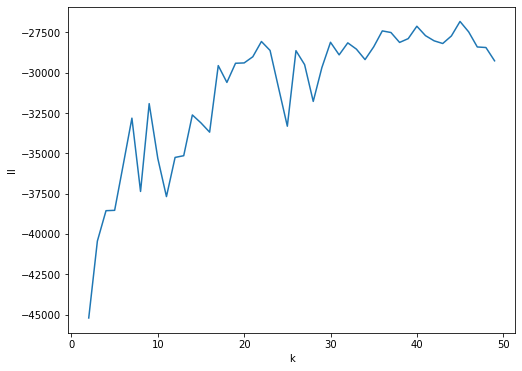

In [74]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,kmax),ll[2:kmax])
ax.set_xlabel('k')
ax.set_ylabel('ll')

<div class="alert alert-block alert-warning"><b>Training and evaluating</b></div>

<div class="alert alert-block alert-info"><b>Note:</b> not finished yet maybe in a future</div>

***The End***